In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential, Model
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Input, Conv1D, MaxPooling1D, UpSampling1D, ConvLSTM2D, Flatten, Reshape, Conv3D, MaxPooling3D, UpSampling3D, Conv3DTranspose
from tensorflow.keras.regularizers import l1

In [ ]:
# Load your dataset
data = pd.read_csv('/content/iot_telemetry_data.csv')

# Select the relevant columns
selected_columns = ['co', 'humidity', 'light', 'lpg', 'motion', 'smoke', 'temp']
data = data[selected_columns]


In [ ]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = 0.8
train_data, test_data = train_test_split(data_scaled, train_size=train_size, random_state=42)


In [ ]:
# Reshape the data for LSTM input
timesteps = 10
num_samples_train = (train_data.shape[0] // timesteps) * timesteps
num_samples_test = (test_data.shape[0] // timesteps) * timesteps
train_data_reshaped = train_data[:num_samples_train].reshape((num_samples_train // timesteps, timesteps, len(selected_columns)))
test_data_reshaped = test_data[:num_samples_test].reshape((num_samples_test // timesteps, timesteps, len(selected_columns)))

# Define the input shape
input_shape = (timesteps, len(selected_columns))




In [ ]:
# Create the LSTM autoencoder model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=input_shape))
lstm_model.add(Dense(int(0.1 * len(selected_columns)), activation='relu'))  # Compression layer
lstm_model.add(RepeatVector(timesteps))
lstm_model.add(LSTM(64, activation='relu', return_sequences=True))
lstm_model.add(TimeDistributed(Dense(len(selected_columns))))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18432     
                                                                 
 dense (Dense)               (None, 0)                 0         
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 0)             0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            16640     
                                                                 
 time_distributed (TimeDist  (None, 10, 7)             455       
 ributed)                                                        
                                                                 
Total params: 35527 (138.78 KB)
Trainable params: 35527 

In [ ]:
# Train the LSTM autoencoder
start_time = time.time()
lstm_model.fit(train_data_reshaped, train_data_reshaped, epochs=10, batch_size=32)
end_time = time.time()
lstm_training_time = end_time - start_time
print("Training Time (LSTM Autoencoder with Compression):", lstm_training_time, "seconds")

# Evaluate the LSTM autoencoder  on the testing data
lstm_loss = lstm_model.evaluate(test_data_reshaped, test_data_reshaped)
print('Test loss (LSTM Autoencoder with Compression):', lstm_loss)

# Make predictions using the trained LSTM autoencoder
lstm_predictions = lstm_model.predict(test_data_reshaped)

Epoch 1/10
1013/1013 [==============================] - 17s 14ms/step - loss: 0.0768
Epoch 2/10
1013/1013 [==============================] - 16s 16ms/step - loss: 0.0363
Epoch 3/10
1013/1013 [==============================] - 17s 17ms/step - loss: 0.0361
Epoch 4/10
1013/1013 [==============================] - 14s 13ms/step - loss: 0.0361
Epoch 5/10
1013/1013 [==============================] - 13s 13ms/step - loss: 0.0361
Epoch 6/10
1013/1013 [==============================] - 13s 13ms/step - loss: 0.0361
Epoch 7/10
1013/1013 [==============================] - 22s 22ms/step - loss: 0.0361
Epoch 8/10
1013/1013 [==============================] - 16s 16ms/step - loss: 0.0361
Epoch 9/10
1013/1013 [==============================] - 14s 14ms/step - loss: 0.0361
Epoch 10/10
1013/1013 [==============================] - 14s 14ms/step - loss: 0.0361
Training Time (LSTM Autoencoder with Compression): 156.7075252532959 seconds
254/254 [==============================] - 2s 5ms/step - loss: 0.0362
Te

In [ ]:
# Create the CAE model
cae_model = Sequential()
cae_model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
cae_model.add(MaxPooling1D(pool_size=2))
cae_model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
cae_model.add(Flatten())
cae_model.add(Dense(int(0.1 * len(selected_columns)), activation='relu'))  # Compression layer
cae_model.add(Dense(16 * timesteps // 2))
cae_model.add(Reshape((timesteps // 2, 16)))
cae_model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
cae_model.add(UpSampling1D(size=2))
cae_model.add(Conv1D(len(selected_columns), kernel_size=3, activation='linear', padding='same'))
cae_model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the CAE model
start_time = time.time()
cae_model.fit(train_data_reshaped, train_data_reshaped, epochs=10, batch_size=32)
end_time = time.time()
cae_training_time = end_time - start_time
print("Training Time (CAE with Compression):", cae_training_time, "seconds")

# Evaluate the CAE model  on the testing data
cae_loss = cae_model.evaluate(test_data_reshaped, test_data_reshaped)
print('Test loss (CAE with Compression):', cae_loss)

# Make predictions using the trained CAE model
cae_predictions = cae_model.predict(test_data_reshaped)

Epoch 1/10
1013/1013 [==============================] - 6s 4ms/step - loss: 0.0768
Epoch 2/10
1013/1013 [==============================] - 3s 3ms/step - loss: 0.0363
Epoch 3/10
1013/1013 [==============================] - 3s 3ms/step - loss: 0.0361
Epoch 4/10
1013/1013 [==============================] - 3s 3ms/step - loss: 0.0361
Epoch 5/10
1013/1013 [==============================] - 4s 4ms/step - loss: 0.0361
Epoch 6/10
1013/1013 [==============================] - 3s 3ms/step - loss: 0.0361
Epoch 7/10
1013/1013 [==============================] - 3s 3ms/step - loss: 0.0361
Epoch 8/10
1013/1013 [==============================] - 3s 3ms/step - loss: 0.0361
Epoch 9/10
1013/1013 [==============================] - 5s 5ms/step - loss: 0.0361
Epoch 10/10
1013/1013 [==============================] - 5s 5ms/step - loss: 0.0361
Training Time (CAE with Compression): 42.845327615737915 seconds
254/254 [==============================] - 1s 2ms/step - loss: 0.0362
Test loss (CAE with Compression): 

In [ ]:
# Reshape the data for ConvLSTM input
train_data_reshaped_convlstm = train_data_reshaped.reshape((train_data_reshaped.shape[0], train_data_reshaped.shape[1], 1, 1, train_data_reshaped.shape[2]))
test_data_reshaped_convlstm = test_data_reshaped.reshape((test_data_reshaped.shape[0], test_data_reshaped.shape[1], 1, 1, test_data_reshaped.shape[2]))

# Create the ConvLSTM model
convlstm_model = Sequential()
convlstm_model.add(ConvLSTM2D(32, kernel_size=(3, 1), activation='relu', padding='same', return_sequences=True, input_shape=(timesteps, 1, 1, len(selected_columns))))
convlstm_model.add(ConvLSTM2D(16, kernel_size=(3, 1), activation='relu', padding='same', return_sequences=True))
convlstm_model.add(ConvLSTM2D(len(selected_columns), kernel_size=(3, 1), activation='linear', padding='same', return_sequences=False))
convlstm_model.add(Flatten())
convlstm_model.add(Dense(int(0.1 * timesteps * len(selected_columns)), activation='relu'))  # Compression layer
convlstm_model.add(Dense(timesteps * len(selected_columns)))
convlstm_model.add(Reshape((timesteps, len(selected_columns))))
convlstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the ConvLSTM model
start_time = time.time()
convlstm_model.fit(train_data_reshaped_convlstm, train_data_reshaped, epochs=10, batch_size=32)
end_time = time.time()
convlstm_training_time = end_time - start_time
print("Training Time (ConvLSTM with Compression):", convlstm_training_time, "seconds")

# Evaluate the ConvLSTM model  on the testing data
convlstm_loss = convlstm_model.evaluate(test_data_reshaped_convlstm, test_data_reshaped)
print('Test loss (ConvLSTM with Compression):', convlstm_loss)

# Make predictions using the trained ConvLSTM model
convlstm_predictions = convlstm_model.predict(test_data_reshaped_convlstm)

Epoch 1/10
1013/1013 [==============================] - 42s 34ms/step - loss: 0.0442
Epoch 2/10
1013/1013 [==============================] - 37s 37ms/step - loss: 0.0284
Epoch 3/10
1013/1013 [==============================] - 38s 38ms/step - loss: 0.0242
Epoch 4/10
1013/1013 [==============================] - 38s 37ms/step - loss: 0.0216
Epoch 5/10
1013/1013 [==============================] - 36s 35ms/step - loss: 0.0214
Epoch 6/10
1013/1013 [==============================] - 37s 36ms/step - loss: 0.0213
Epoch 7/10
1013/1013 [==============================] - 35s 34ms/step - loss: 0.0211
Epoch 8/10
1013/1013 [==============================] - 36s 36ms/step - loss: 0.0205
Epoch 9/10
1013/1013 [==============================] - 34s 34ms/step - loss: 0.0193
Epoch 10/10
1013/1013 [==============================] - 38s 38ms/step - loss: 0.0186
Training Time (ConvLSTM with Compression): 371.64992570877075 seconds
254/254 [==============================] - 2s 7ms/step - loss: 0.0186
Test loss

In [ ]:
# Calculate the reconstruction accuracy
mae_lstm = mean_absolute_error(test_data_reshaped.reshape(-1, len(selected_columns)), lstm_predictions.reshape(-1, len(selected_columns)))
reconstruction_accuracy_lstm = (1 - mae_lstm) * 100

mae_cae = mean_absolute_error(test_data_reshaped.reshape(-1, len(selected_columns)), cae_predictions.reshape(-1, len(selected_columns)))
reconstruction_accuracy_cae = (1 - mae_cae) * 100

mae_convlstm = mean_absolute_error(test_data_reshaped.reshape(-1, len(selected_columns)), convlstm_predictions.reshape(-1, len(selected_columns)))
reconstruction_accuracy_convlstm = (1 - mae_convlstm) * 100

print("Reconstruction Accuracy (LSTM Autoencoder):")
print("Mean Absolute Error (MAE):", mae_lstm)
print("Reconstruction Accuracy: {:.2f}%".format(reconstruction_accuracy_lstm))

print("Reconstruction Accuracy (CAE):")
print("Mean Absolute Error (MAE):", mae_cae)
print("Reconstruction Accuracy: {:.2f}%".format(reconstruction_accuracy_cae))


print("Reconstruction Accuracy (ConvLSTM):")
print("Mean Absolute Error (MAE):", mae_convlstm)
print("Reconstruction Accuracy: {:.2f}%".format(reconstruction_accuracy_convlstm))

Reconstruction Accuracy (LSTM Autoencoder):
Mean Absolute Error (MAE): 0.11544286026152686
Reconstruction Accuracy: 88.46%
Reconstruction Accuracy (CAE):
Mean Absolute Error (MAE): 0.11501310039168475
Reconstruction Accuracy: 88.50%
Reconstruction Accuracy (ConvLSTM):
Mean Absolute Error (MAE): 0.08339290688571487
Reconstruction Accuracy: 91.66%


In [ ]:
# Create a hybrid model of ConvLSTM and RNN
convlstm_rnn_model = Sequential()
convlstm_rnn_model.add(ConvLSTM2D(32, kernel_size=(3, 1), activation='relu', padding='same', return_sequences=True, input_shape=(timesteps, 1, 1, len(selected_columns))))
convlstm_rnn_model.add(ConvLSTM2D(16, kernel_size=(3, 1), activation='relu', padding='same', return_sequences=False))
convlstm_rnn_model.add(Flatten())
convlstm_rnn_model.add(Dense(int(0.1 * timesteps * len(selected_columns)), activation='relu'))  # Compression layer (90% compression)
convlstm_rnn_model.add(Dense(64, activation='relu'))
convlstm_rnn_model.add(Dense(timesteps * len(selected_columns)))
convlstm_rnn_model.add(Reshape((timesteps, len(selected_columns))))
convlstm_rnn_model.compile(optimizer='adam', loss='mse')


In [ ]:
# Train the hybrid ConvLSTM-RNN model
start_time = time.time()
convlstm_rnn_history = convlstm_rnn_model.fit(train_data_reshaped_convlstm, train_data_reshaped, epochs=10, batch_size=64, validation_data=(test_data_reshaped_convlstm, test_data_reshaped))
end_time = time.time()
convlstm_rnn_training_time = end_time - start_time
print("Training Time (ConvLSTM-RNN):", convlstm_rnn_training_time, "seconds")

Epoch 1/10
507/507 [==============================] - 22s 32ms/step - loss: 0.0453 - val_loss: 0.0332
Epoch 2/10
507/507 [==============================] - 15s 30ms/step - loss: 0.0303 - val_loss: 0.0272
Epoch 3/10
507/507 [==============================] - 16s 31ms/step - loss: 0.0257 - val_loss: 0.0239
Epoch 4/10
507/507 [==============================] - 15s 30ms/step - loss: 0.0224 - val_loss: 0.0212
Epoch 5/10
507/507 [==============================] - 15s 30ms/step - loss: 0.0206 - val_loss: 0.0203
Epoch 6/10
507/507 [==============================] - 16s 31ms/step - loss: 0.0196 - val_loss: 0.0188
Epoch 7/10
507/507 [==============================] - 18s 35ms/step - loss: 0.0180 - val_loss: 0.0174
Epoch 8/10
507/507 [==============================] - 16s 31ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 9/10
507/507 [==============================] - 16s 32ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 10/10
507/507 [==============================] - 16s 31ms/step - loss: 0.015

In [ ]:
# Evaluate the hybrid ConvLSTM-RNN model on the testing data
convlstm_rnn_loss = convlstm_rnn_model.evaluate(test_data_reshaped_convlstm, test_data_reshaped)
print('Test loss (ConvLSTM-RNN):', convlstm_rnn_loss)

# Make predictions using the trained hybrid ConvLSTM-RNN model
convlstm_rnn_predictions = convlstm_rnn_model.predict(test_data_reshaped_convlstm)

254/254 [==============================] - 2s 8ms/step - loss: 0.0153
Test loss (ConvLSTM-RNN): 0.015341118909418583
254/254 [==============================] - 2s 5ms/step


In [ ]:

# Calculate the reconstruction accuracy for the hybrid model
mae_convlstm_rnn = mean_absolute_error(test_data_reshaped.reshape(-1, len(selected_columns)), convlstm_rnn_predictions.reshape(-1, len(selected_columns)))

reconstruction_accuracy_convlstm_rnn = (1 - mae_convlstm_rnn) * 100


print("Reconstruction Accuracy (ConvLSTM-RNN):")
print("Mean Absolute Error (MAE):", mae_convlstm_rnn)
print("Reconstruction Accuracy: {:.2f}%".format(reconstruction_accuracy_convlstm_rnn))



Reconstruction Accuracy (ConvLSTM-RNN):
Mean Absolute Error (MAE): 0.05927669064726095
Reconstruction Accuracy: 94.07%


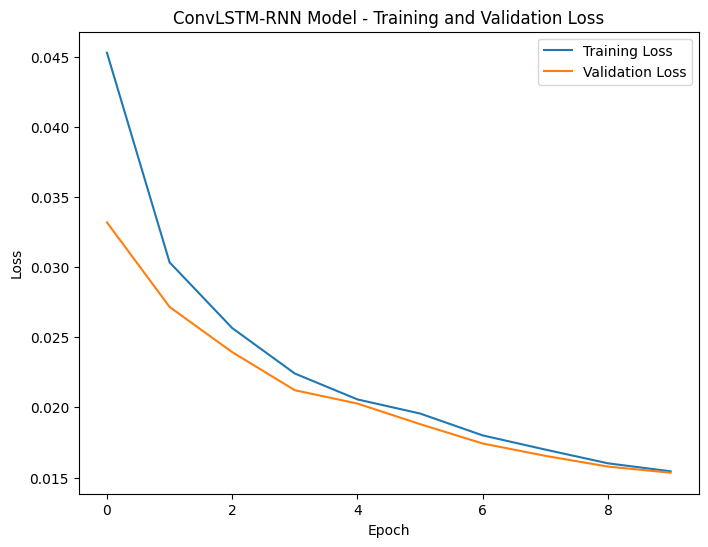

In [ ]:
# Visualize the training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(convlstm_rnn_history.history['loss'], label='Training Loss')
plt.plot(convlstm_rnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ConvLSTM-RNN Model - Training and Validation Loss')
plt.legend()
plt.show()

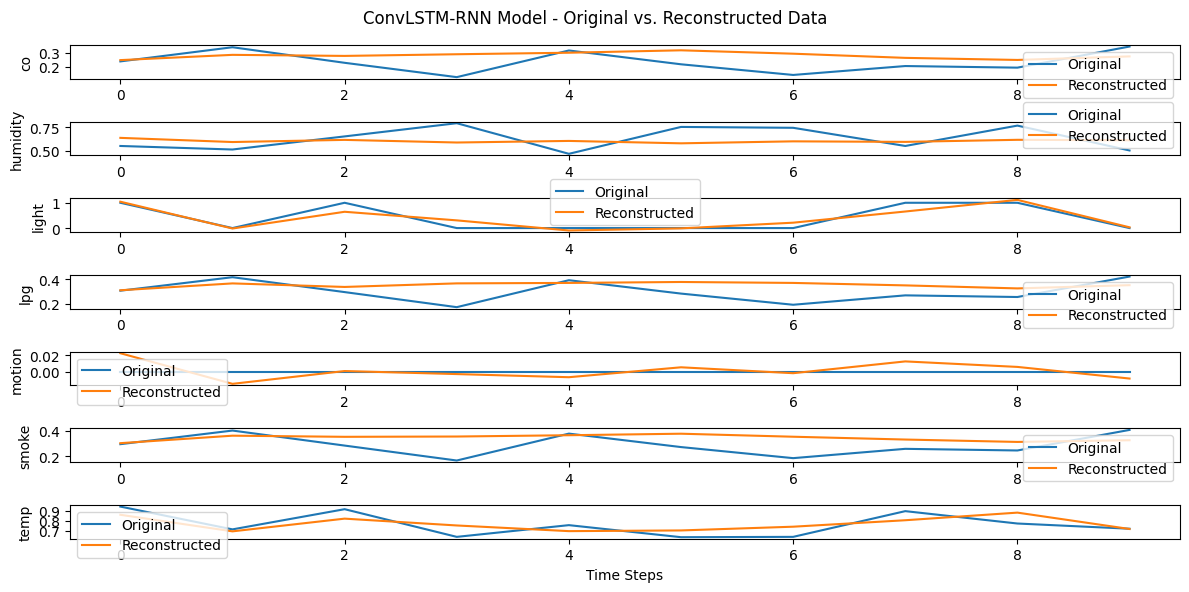

In [ ]:
# Visualize the reconstructed data
sample_index = 0
original_data = test_data_reshaped[sample_index]
reconstructed_data = convlstm_rnn_predictions[sample_index]

plt.figure(figsize=(12, 6))
for i in range(len(selected_columns)):
    plt.subplot(len(selected_columns), 1, i+1)
    plt.plot(original_data[:, i], label='Original')
    plt.plot(reconstructed_data[:, i], label='Reconstructed')
    plt.ylabel(selected_columns[i])
    plt.legend()
plt.xlabel('Time Steps')
plt.suptitle('ConvLSTM-RNN Model - Original vs. Reconstructed Data')
plt.tight_layout()
plt.show()

<ipython-input-18-8a64c494d57b>:8: RuntimeWarning: divide by zero encountered in divide
  normalized_feature_mae = feature_mae / feature_ranges


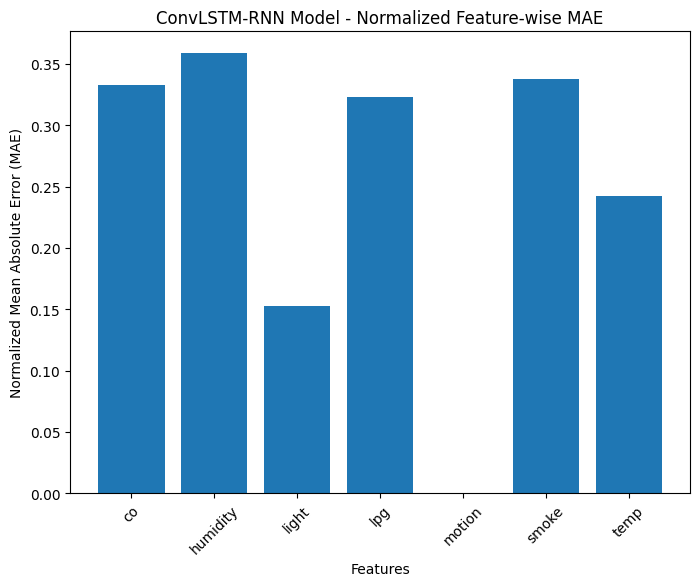

In [ ]:
# Calculate the range of each feature
feature_ranges = np.max(original_data, axis=0) - np.min(original_data, axis=0)

# Calculate the feature-wise MAE
feature_mae = np.mean(np.abs(original_data - reconstructed_data), axis=0)

# Normalize the feature-wise MAE by the range of each feature
normalized_feature_mae = feature_mae / feature_ranges

plt.figure(figsize=(8, 6))
plt.bar(selected_columns, normalized_feature_mae)
plt.xlabel('Features')
plt.ylabel('Normalized Mean Absolute Error (MAE)')
plt.title('ConvLSTM-RNN Model - Normalized Feature-wise MAE')
plt.xticks(rotation=45)
plt.show()

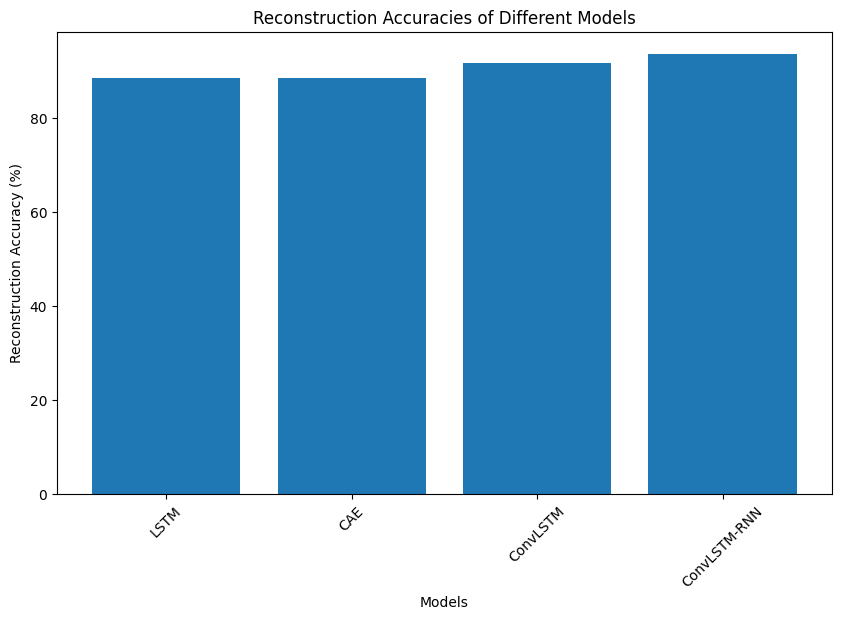

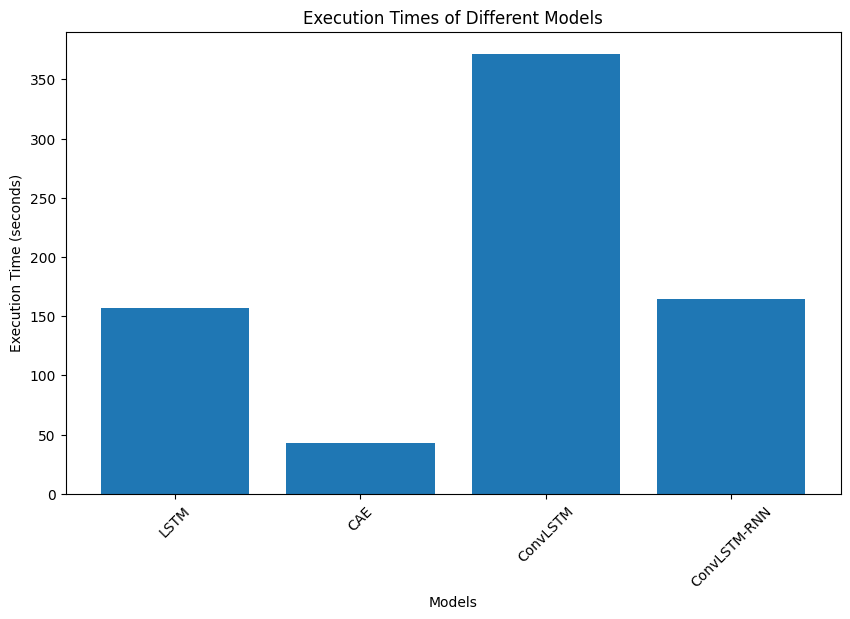

In [ ]:


models = ['LSTM', 'CAE', 'ConvLSTM', 'ConvLSTM-RNN']



# Visualize the reconstruction accuracies of all models
reconstruction_accuracies = [
    reconstruction_accuracy_lstm,
    reconstruction_accuracy_cae,
    reconstruction_accuracy_convlstm,
    reconstruction_accuracy_convlstm_rnn
]

plt.figure(figsize=(10, 6))
plt.bar(models, reconstruction_accuracies)
plt.xlabel('Models')
plt.ylabel('Reconstruction Accuracy (%)')
plt.title('Reconstruction Accuracies of Different Models')
plt.xticks(rotation=45)
plt.show()

# Visualize the execution times of all models
execution_times = [
    lstm_training_time,
    cae_training_time,
    convlstm_training_time,
    convlstm_rnn_training_time
]

plt.figure(figsize=(10, 6))
plt.bar(models, execution_times)
plt.xlabel('Models')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Times of Different Models')
plt.xticks(rotation=45)
plt.show()


In [ ]:
pip install keras_sequential_ascii

  Preparing metadata (setup.py) ... done
  Created wheel for keras_sequential_ascii: filename=keras_sequential_ascii-0.1.1-py3-none-any.whl size=3042 sha256=feb54efd436597bb2795f4cb2814a47af3b0e2703d1f60d33352b0b772e47f77
  Stored in directory: /root/.cache/pip/wheels/50/10/f3/5eeae758ef81ee4e16d618471561509355b0f2e5f38bf41185
Successfully built keras_sequential_ascii


In [ ]:
!pip install pydot
!pip install graphviz

import pydot
import graphviz

from tensorflow.keras.utils import plot_model

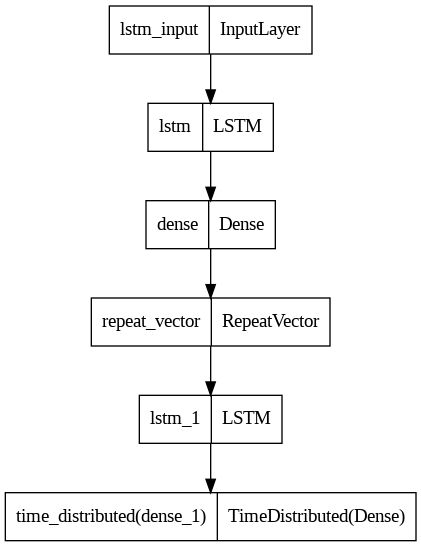

In [ ]:
plot_model(lstm_model)

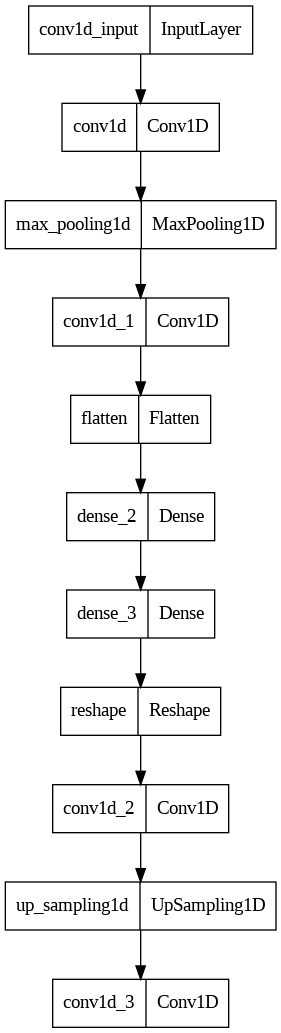

In [ ]:
plot_model(cae_model)

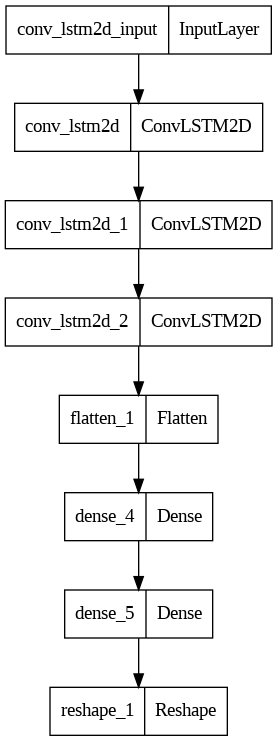

In [ ]:
plot_model (convlstm_model)

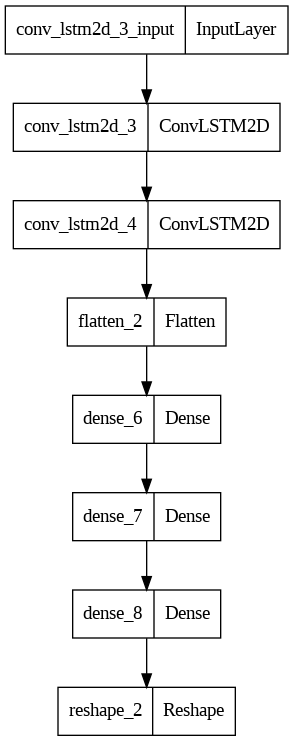

In [ ]:
 plot_model(convlstm_rnn_model)